# Прогнозирование поведения клиента (ДЗ)

Привет!

В последнем домашнем задании Интенсива тебе предстоит построить кривые def rate, внедрить ее в NPV-модель и зависимость обновленной модели от выбранного скора (подробные пункты перечислены ниже).  
Для выполнения тебе понадобится выборка с данными, которую использовали на семинаре (**data_vintages.csv**), x_score и PD (**data_scores.csv**). Не бойся выходить за рамки методов, предлженных в лекции.  
Главное - не забывай **аргументировать** свой выбор и давать **комментарии** своим действиям. 

Удачи!

#### Как будет оцениваться работа:
За это ДЗ ты можешь получить максимум **10 баллов**. Все пункты весят по-разному, баллы указаны рядом с пунктами. Баллы могут сниматься в случае неполного выполнения задания или отсутствия аргументации.


#### Задачи:

1) Построить кривые DEF rate (5 баллов)
    - Выбрать переменную для разбивки по бакетам (0.5 балла)
    - Провести анализ поколений (0.5 балла)
    - Построить винтажи DEF rate (0.5 балла)
    - Провести анализ на особые точки (0.5 балла)
    - Провести анализ наличия внешних воздействий и при необходимости вычистить кривые (2 балла)
    - Построить среднее по винтажам для каждого бакета (0.5 балла)
    - Сгладить кривые (0.5 балла)
    
2) Внести в модель построенную кривую DEF rate и исследовать зависимость от скора (5 баллов)
    - Реализовать метод для расчета DEF rate по поданному скору (3 балла)
    - Рассчитать NPV для кредита с заданными параметрами (1 балл)
    - Построить кривую зависимости NPV от скора (1 балл)
    
**Пожалйуста, аргументируйте свои решения по каждому пункту**

В качестве результата по пунктам 2 и 3 приложи текущий ноутбук с названием 'Surname_def.ipynb'

## Кривые DEF rate

#### Выгружаем данные с винтажами

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

from scipy.optimize import minimize
from sklearn.metrics import r2_score

In [2]:
# В качестве данных для винтажей используй файл с семинара data_vintages.csv

df = pd.read_csv(
    "data_vintages.csv",
    sep=";",
    encoding="cp1251",
    index_col=0,
    parse_dates=["gen_month_dt", "gen_quarter_dt"],
)
df.head(10)

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0,0,0
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0,0,1
3,39035,23,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0
5,13089,14,2019-03-01,2019-01-01,0,0,0,1,0,0,0,1
6,132017,7,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0
7,67966,24,2019-06-01,2019-04-01,1,0,0,0,1,0,0,0
8,152759,11,2019-11-01,2019-10-01,0,0,1,1,0,0,0,1
9,128462,20,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0


#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

In [3]:
# Тебе понадобятся два скора pd_score и x_score из файла data_scores.csv 
df_scores = pd.read_csv(
    "data_scores.csv", sep=";", encoding="cp1251", decimal=",", index_col=0
)

df_scores.head(10)

,user_id,pd,x_score
0,9311,0.035025,0.219980
1,155026,0.046279,0.146986
2,17584,0.007221,0.343298
3,156231,0.069679,0.186684
4,123587,0.010402,0.305582
5,125519,0.032667,0.261228
6,123890,0.027963,0.199389
7,82137,0.073694,0.113313
8,55227,0.011746,0.335474
9,124825,0.049237,0.227262


#### Бьем выборку на бакеты и джойним с данными с винтажами

In [4]:
# Разбей данные на 3 бакета по каждой переменной
df_scores = df_scores.sort_values(["pd"], ignore_index=True)
df_scores["pd_bucket"] = np.minimum(df_scores.index // (df_scores.shape[0] // 3), 2)
print(df_scores.groupby(["pd_bucket"])["pd"].mean())

df_scores = df_scores.sort_values(["x_score"], ignore_index=True)
df_scores["x_bucket"] = np.minimum(df_scores.index // (df_scores.shape[0] // 3), 2)
print(df_scores.groupby(["x_bucket"])["x_score"].mean())

df = df.merge(
    df_scores[["user_id", "pd_bucket", "x_bucket", "pd", "x_score"]],
    how="left",
    on="user_id",
).dropna()


df.head()

pd_bucket
0    0.011040
1    0.032685
2    0.068209
Name: pd, dtype: float64
x_bucket
0    0.133270
1    0.220838
2    0.379452
Name: x_score, dtype: float64


,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,pd_bucket,x_bucket,pd,x_score
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1,1,2,0.021296,0.469410
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0,0,0,2,0,0.064742,0.157215
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0,0,1,0,2,0.018490,0.469583
3,39035,23,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1,1,1,0.025882,0.210896
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0,1,1,0.024330,0.269492


### Выбери переменную, которая делит кривые наилучшим образом (0.5 баллов)

 Из двух скоров (x_score и ваш PD) выбери тот, который разделяет кривые наилучшим образом

In [5]:
def plot_def_rate_by_bucket(df, bucket):
#     код функции
    return (
        df.groupby([bucket, "statement_num"])
        .agg({"def_flg": np.sum, "act_flg": np.sum, "user_id": np.count_nonzero})
        .rename(columns={"def_flg": "def_cnt", "act_flg": "act_cnt", "user_id": "cnt"})
        .eval("def_rate = def_cnt / act_cnt", inplace=False)
        .unstack(bucket)["def_rate"]
        .plot(ax=None, figsize=(10, 6), grid=True, lw=3)
    )

/var/folders/z_/d0y9gfdn1w5475vgs7zb15ph0000gn/T/ipykernel_5244/410825660.py:5: FutureWarning: The provided callable <function sum at 0x1047382c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"def_flg": np.sum, "act_flg": np.sum, "user_id": np.count_nonzero})


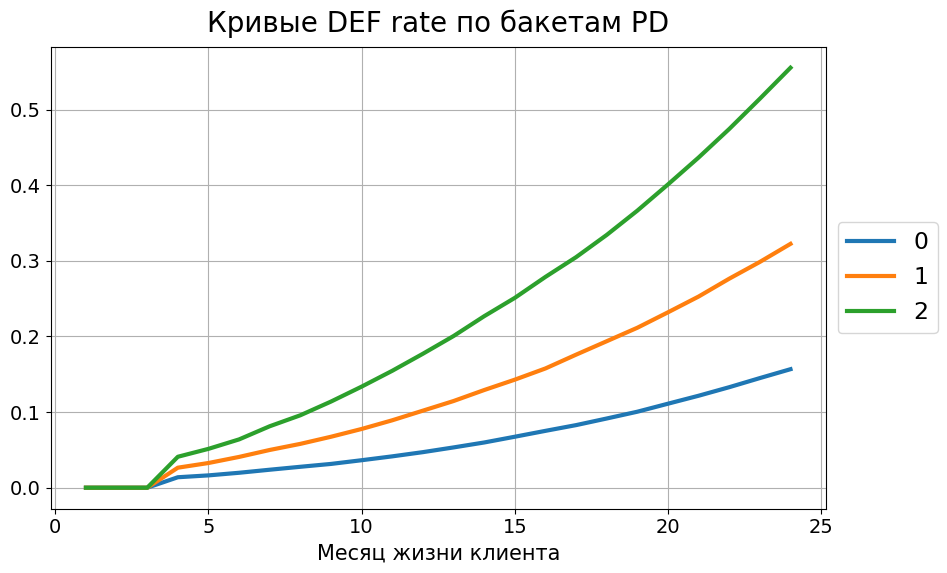

In [6]:
plot_def_rate_by_bucket(df, "pd_bucket")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Кривые DEF rate по бакетам PD", size=20, verticalalignment="bottom")
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()


/var/folders/z_/d0y9gfdn1w5475vgs7zb15ph0000gn/T/ipykernel_5244/410825660.py:5: FutureWarning: The provided callable <function sum at 0x1047382c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"def_flg": np.sum, "act_flg": np.sum, "user_id": np.count_nonzero})


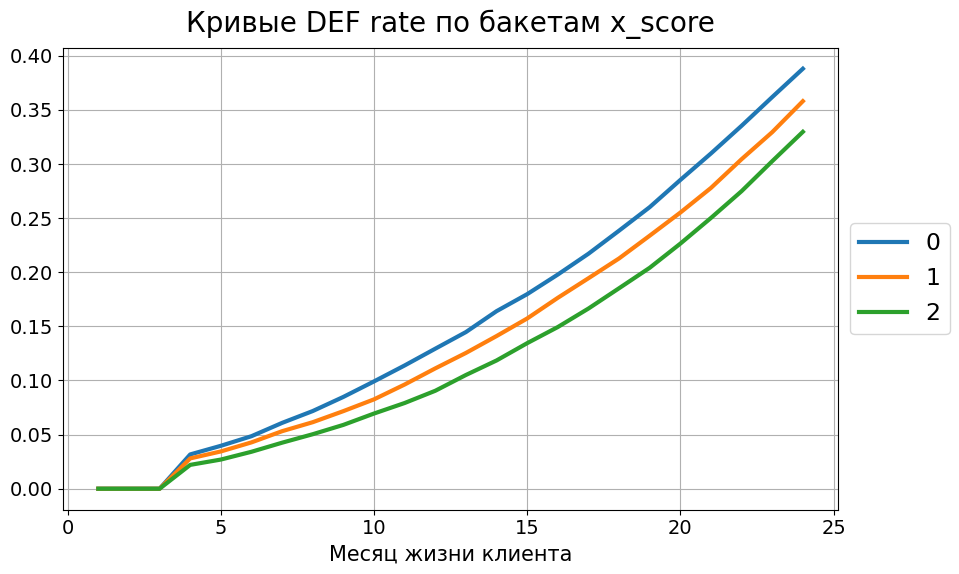

In [7]:
plot_def_rate_by_bucket(df, "x_bucket")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Кривые DEF rate по бакетам x_score", size=20, verticalalignment="bottom")
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

#### Вывод: При использовании PD кривые лежат дальше друг от друга, чем при использовании X_score, поэтому будем использовать PD

### Анализ поколений (0.5 баллов)

Отрисуй распределение данных во времени в разбивке по выбранной перменной

In [8]:
def plot_distribution(df, bucket):
    df = df.set_index("gen_month_dt")
    df.index = df.index.to_period(freq="M")

    return (
        pd.pivot_table(
            df,
            index=bucket,
            columns="gen_month_dt",
            values="user_id",
            aggfunc=np.count_nonzero,
            fill_value=0,
        )
        .T
        .plot(kind="bar", stacked=True, figsize=(15, 9))
    )

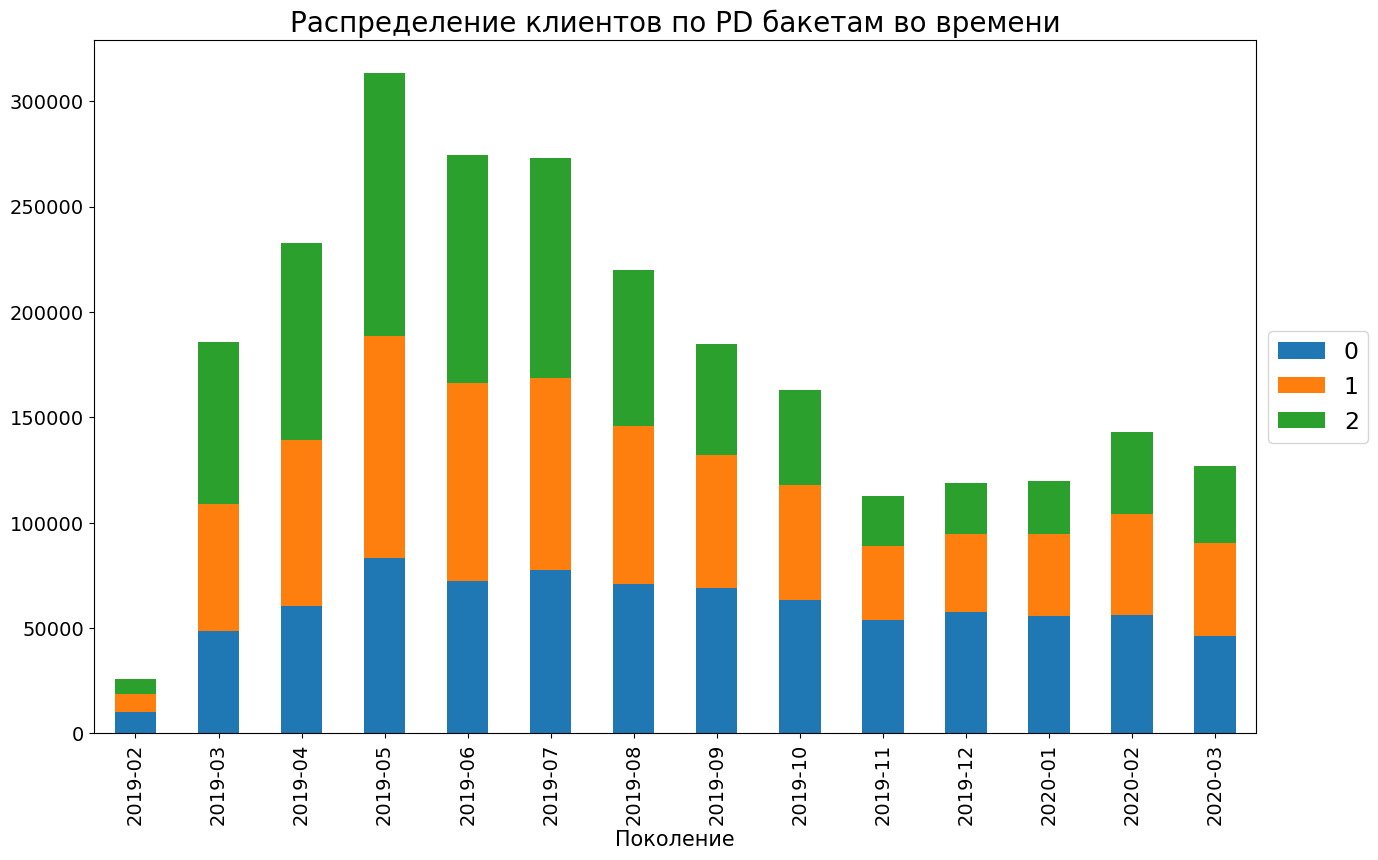

In [9]:
plot_distribution(df, "pd_bucket")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Распределение клиентов по PD бакетам во времени", size=20)
plt.xlabel("Поколение", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

#### Вывод: сделай выводы по полученным графикам. Нужно ли исключать какие-то бакеты/поколения? Если да, то реализуй их исключение из выборки

В 2019-02 мало наблюдений, исключим это поколение из рассмотрения

In [10]:
df = df.loc[df["gen_month_dt"] != "2019-02-01"]
# df = df.loc[df["gen_month_dt"] != "2019-11-01"]
# df = df.loc[df["gen_month_dt"] != "2019-12-01"]
# df = df.loc[df["gen_month_dt"] != "2020-01-01"]

### Кривые DEF Rate в разбивке по бакетам (0.5 баллов)

Реализуй функцию, которая отрисовывает винтажи DEF rate в разбивке по бакетам

/var/folders/z_/d0y9gfdn1w5475vgs7zb15ph0000gn/T/ipykernel_5244/1871441374.py:8: FutureWarning: The provided callable <function sum at 0x1047382c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"def_flg": np.sum, "act_flg": np.sum, "user_id": np.count_nonzero})
/var/folders/z_/d0y9gfdn1w5475vgs7zb15ph0000gn/T/ipykernel_5244/1871441374.py:8: FutureWarning: The provided callable <function sum at 0x1047382c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"def_flg": np.sum, "act_flg": np.sum, "user_id": np.count_nonzero})
/var/folders/z_/d0y9gfdn1w5475vgs7zb15ph0000gn/T/ipykernel_5244/1871441374.py:8: FutureWarning: The provided callable <function sum at 0x1047382c0> is currently using SeriesGroupBy.sum. In a future version of pan

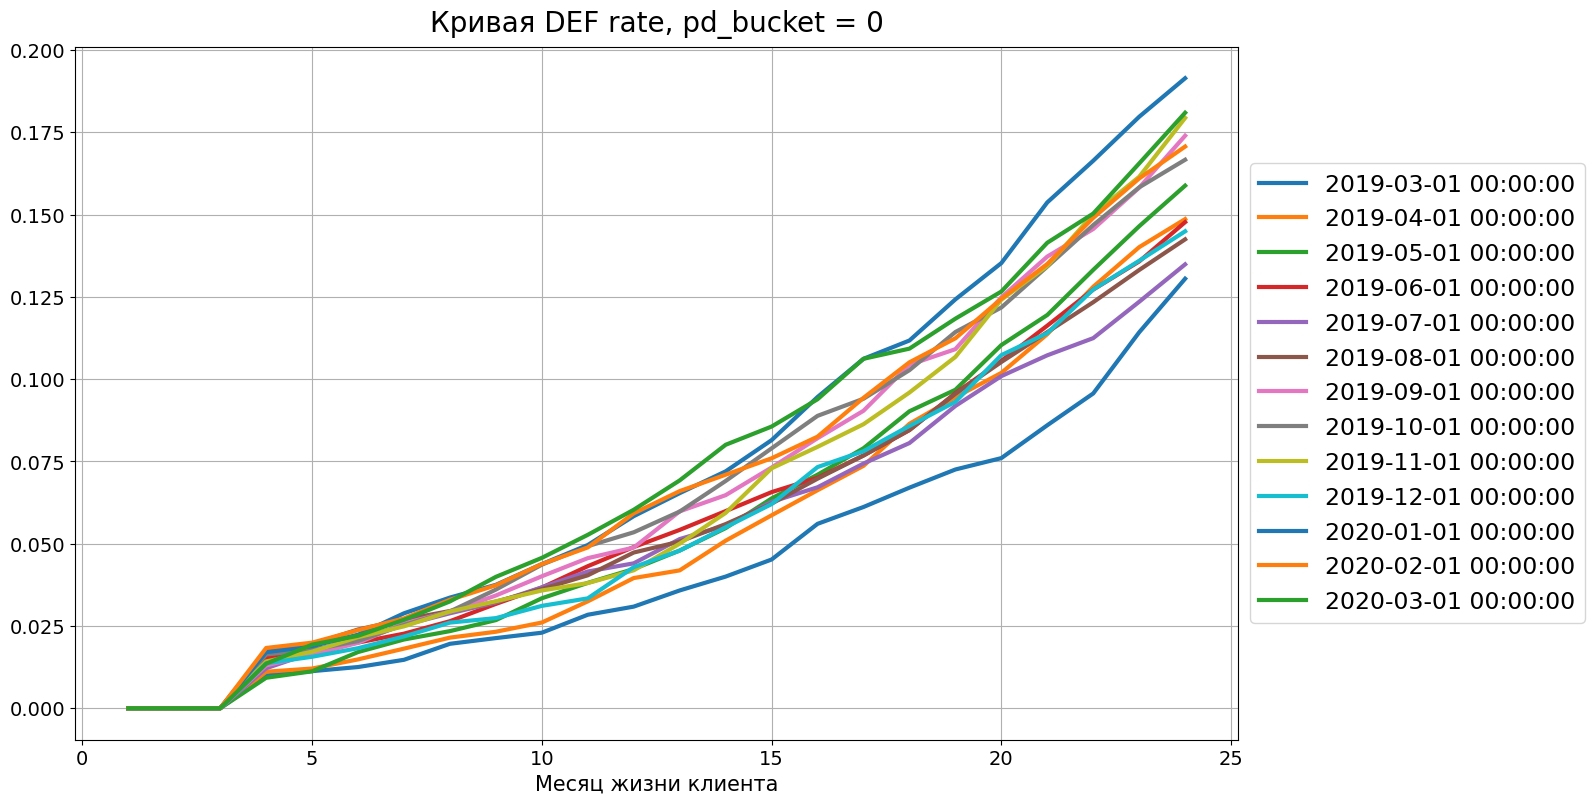

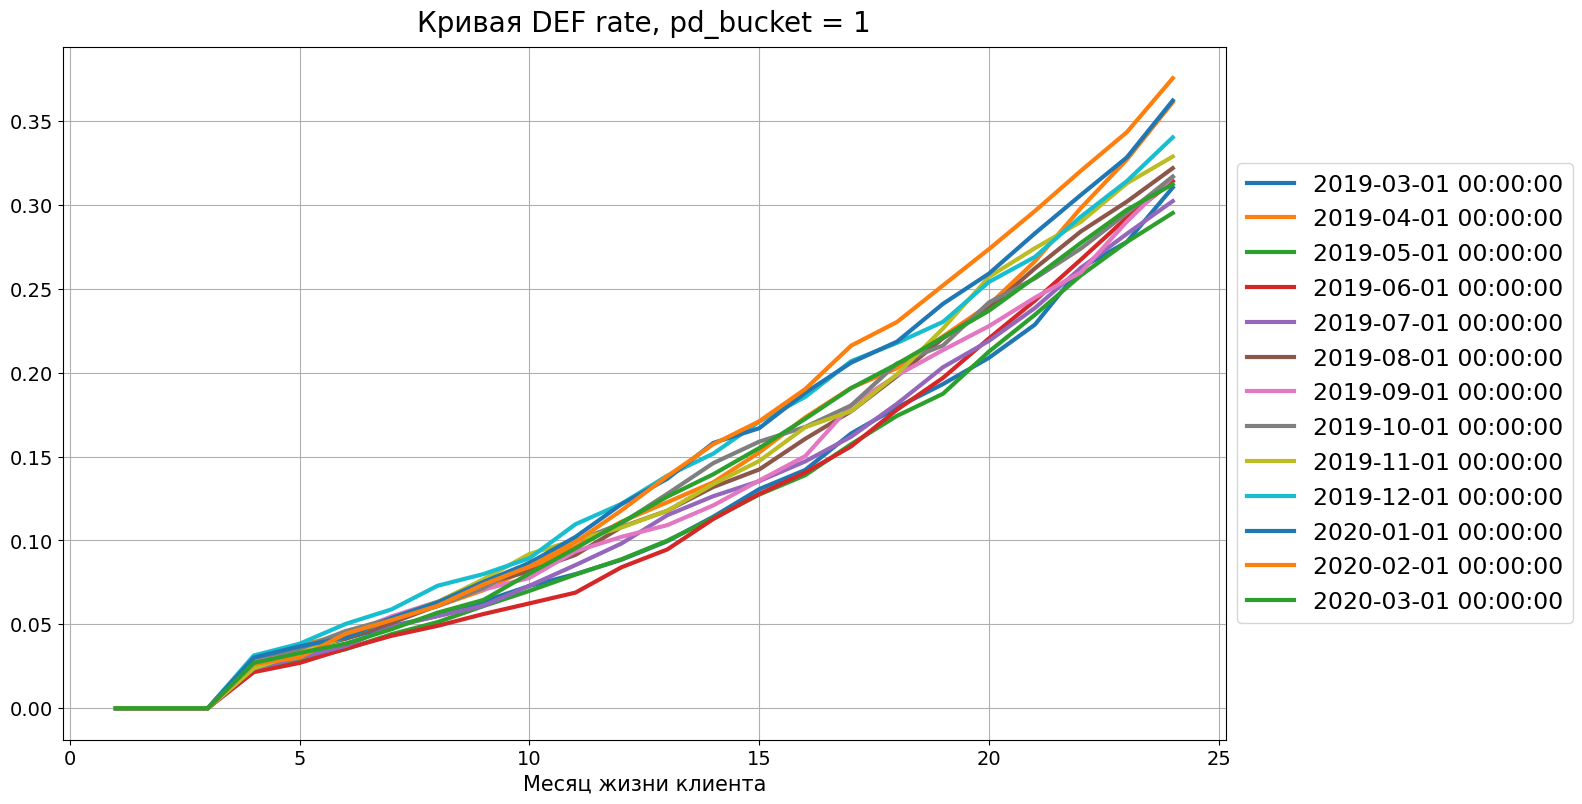

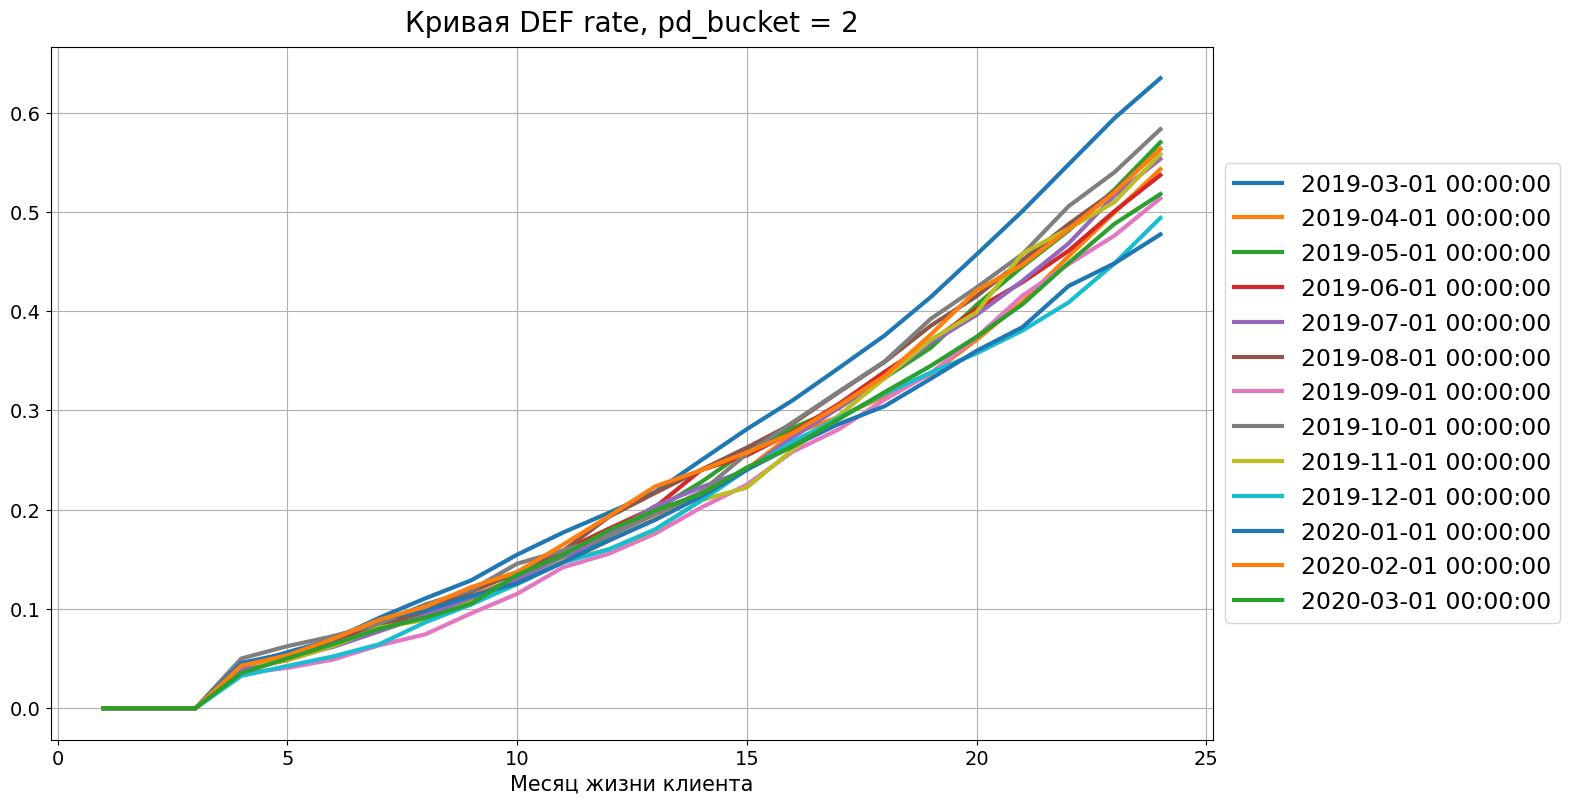

In [11]:
buckets = df["pd_bucket"].unique()


def plot_def_rate_by_generation(data, pd_bucket):
    (
        data.query(""" pd_bucket == @pd_bucket""")
        .groupby(["gen_month_dt", "statement_num"])
        .agg({"def_flg": np.sum, "act_flg": np.sum, "user_id": np.count_nonzero})
        .rename(
            columns=({"def_flg": "def_cnt", "act_flg": "act_cnt", "user_id": "cnt"})
        )
        .eval("def_rate = def_cnt / act_cnt", inplace=False)
        .unstack("gen_month_dt")["def_rate"]
        .plot(ax=None, figsize=(15, 9), grid=True, lw=3)
    )
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
    plt.title(
        "Кривая DEF rate, pd_bucket = " + str(pd_bucket),
        size=20,
        verticalalignment="bottom",
    )
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis="both", which="major", labelsize=14)



for i in sorted(buckets):
    plot_def_rate_by_generation(df, i)

#### Выводы: сделай выводы по полученным графикам

Кривые DEF rate устойчивы, критически плохих поколений не видно

### Особые точки (0.5 баллов) 
#### Есть ли в винтажах особые точки? Укажи их. Какова их природа? Нужно ли их исключать?

Есть особые точки в месяцах 3 и 4(там наблюдается излом). Дефолты начинают появляться только после накопления просрочки глубиной 4 месяца. Данные можно оставить целиком и учитывать эти эффекты на этапе сглаживания

### Макроэкономические воздействие (2 балла)

#### Есть ли в винтажах DEF rate макроэкономическое воздействие (нарисуй график иллюстрирующее это воздействие)? Если да, то предположи какое событие его вызвало и почему?
#### В случае наличия внешнего влияния 
#### 1) Разложи кривые на внешнее воздействие и созревание кривых
#### 2) Отрисуй график внешнего воздествия
#### 3) Отрисуй вычищенные винтажи DEF rate в разбивке по бакетам
#### 4) Посчитай среднее для этих бакетов и реализуй сглаживание

In [12]:
def curve_build(data, feature, generation="generation_quart",
                statement_num="statement_num", group_label="1", stable_from=6):

    df_query = data.sort_values([generation, statement_num]).reset_index(drop=True)

    generation_min = df_query[generation].min()

    values = df_query[feature].to_numpy(dtype=float)
    st_nums = (df_query[statement_num].to_numpy(dtype=int) - 1)   # возраст a=0..A-1

    # календарный индекс t=0..T-1 для каждой строки
    dates = (
        df_query[generation].dt.year * 12 + df_query[generation].dt.month
        - (generation_min.year * 12 + generation_min.month)
        + df_query[statement_num].to_numpy(dtype=int) - 1
    ).to_numpy(dtype=int)

    A = int(st_nums.max() + 1)          # длина M(a)
    T = int(dates.max() + 1)            # длина E(t)
    tab_size = len(df_query)

    stable_mask = (np.arange(T) >= stable_from)  # t>=6

    def unpack_x(x):
        E_raw = x[:T]
        M_raw = x[T:T+A]

        # среднее только по "стабильному" окну
        if stable_mask.any():
            mean_E = E_raw[stable_mask].mean()
        else:
            mean_E = E_raw.mean()

        if mean_E == 0:
            mean_E = 1e-12

        # теперь mean(E[stable_mask]) == 1
        E = E_raw / mean_E

        # сохраняем инвариантность произведения E*M
        M = M_raw * mean_E
        return E, M

    def r_square(x):
        E, M = unpack_x(x)
        pred = E[dates] * M[st_nums]
        return np.sum((values - pred) ** 2)

    x0 = np.ones(T + A, dtype=float)

    res0 = minimize(
        r_square,
        x0,
        tol=1e-6,
        method="Powell",
        options={"disp": False, "maxiter": 1000},
    )

    # достаем уже нормированные E и M
    E_hat, M_hat = unpack_x(res0.x)

    external_data = pd.DataFrame({
        "month_dt": [generation_min + pd.DateOffset(months=i) for i in range(T)],
        group_label: E_hat
    })

    maturation_data = pd.DataFrame({
        "statement_num": np.arange(1, A + 1),
        group_label: M_hat
    })

    # fitted: D / E (если хотите "очистить" от макро)
    df_query = df_query.copy()
    df_query["month_dt"] = pd.to_datetime(df_query["month_dt"], errors="coerce")
    external_data["month_dt"] = pd.to_datetime(external_data["month_dt"], errors="coerce")

    df_fitted = df_query.merge(external_data, on="month_dt", how="left")
    df_fitted["fitted_feature"] = df_fitted[feature] / df_fitted[group_label]

    return {
        "res0": res0,
        "external_data": external_data,
        "maturation_data": maturation_data,
        "df_fitted": df_fitted,
    }

def decomposition(
    df,
    generation="generation_month",
    group="bucket",
    statement_num="statement_num",
    feature="feature",
    optimization_query="",
):
    """Винтажи исследуемой переменной по календарному времени

    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов

    if optimization_query == "":
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)

    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x - 1))
    df_query["month_dt"] = df_query[generation] + timedelta

    # Формируем список бакетов

    df_query.sort_values(by=[group], inplace=True)
    groups = pd.Series(df_query[group].drop_duplicates())

    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + " = " + str(g))

        # Строим разложение для одного бакета
        res = curve_build(
            df_temp,
            feature=feature,
            generation=generation,
            statement_num=statement_num,
            group_label=str(g),
        )
        df_fitted_temp = pd.DataFrame(res["df_fitted"])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res["external_data"])[["month_dt", str(g)]]
            maturation_data = pd.DataFrame(res["maturation_data"])[
                [statement_num, str(g)]
            ]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(
                right=res["external_data"], on=["month_dt"]
            )
            maturation_data = maturation_data.merge(
                right=res["maturation_data"], on=[statement_num]
            )
            df_fitted = pd.concat([df_fitted, df_fitted_temp])
        i += 1

    # print(res)

    res_multiple = {
        "external_data": external_data,
        "maturation_data": maturation_data,
        "fitted_data": df_fitted,
    }
    return res_multiple

In [13]:
df_def = (
    df.groupby(["pd_bucket", "gen_month_dt", "statement_num"], as_index=False)
    .agg({"def_flg": np.sum, "act_flg": np.sum, "user_id": np.count_nonzero})
    .rename(columns={"def_flg": "def_cnt", "act_flg": "act_cnt", "user_id": "cnt"})
    .eval("def_rate = def_cnt / act_cnt", inplace=False)
)

/var/folders/z_/d0y9gfdn1w5475vgs7zb15ph0000gn/T/ipykernel_5244/1130808519.py:3: FutureWarning: The provided callable <function sum at 0x1047382c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"def_flg": np.sum, "act_flg": np.sum, "user_id": np.count_nonzero})


In [14]:
Nfeval = 0

res_def = decomposition(
    df_def,
    generation="gen_month_dt",
    group="pd_bucket",
    statement_num="statement_num",
    feature="def_rate",
)

/var/folders/z_/d0y9gfdn1w5475vgs7zb15ph0000gn/T/ipykernel_5244/2580818573.py:122: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_query["month_dt"] = df_query[generation] + timedelta


pd_bucket = 0
pd_bucket = 1
pd_bucket = 2


In [15]:
stable_from = 6

E = res_def["external_data"][["0", "1", "2"]].to_numpy()
t = np.arange(len(E))
mask = t >= stable_from

mean_stable = E[mask].mean()
print("Mean(E):", mean_stable)

Mean(E): 1.0


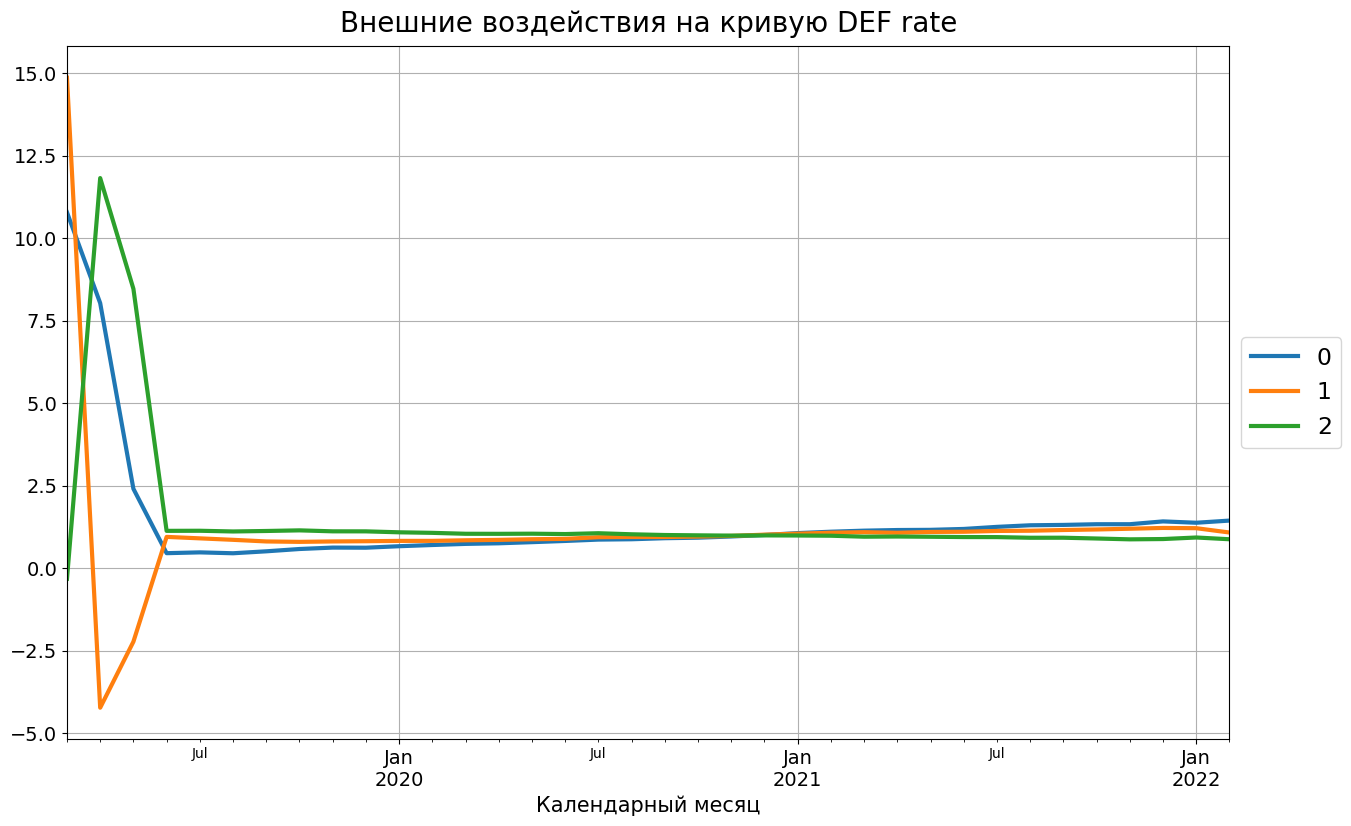

In [16]:
res_def["external_data"].set_index("month_dt").plot(
    ax=None, figsize=(15, 9), grid=True, lw=3
)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title(
    "Внешние воздействия на кривую DEF rate",
    size=20,
    verticalalignment="bottom",
)
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

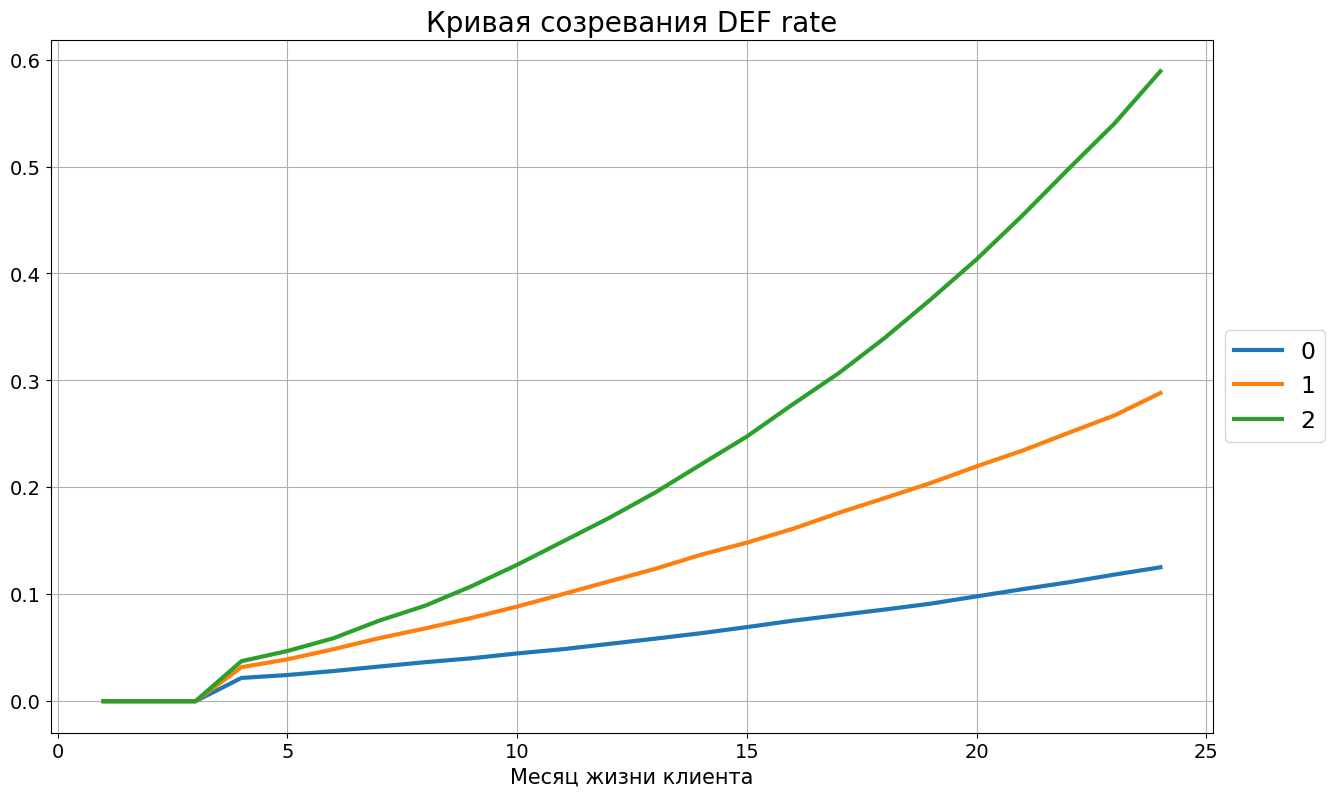

In [17]:
res_def["maturation_data"] \
    .set_index("statement_num") \
    .plot(figsize=(15, 9), grid=True, lw=3)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Кривая созревания DEF rate", size=20)
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

### Среднее по бакетам (0.5 баллов) 
Выбери один из способой нахождение средней кривой (возможные способы указаны в лекции). Обоснуй свой выбор.

Реализуй функцию построения среднего.

In [18]:
def_rate_mean = (
    res_def["fitted_data"]
    .groupby(["pd_bucket", "statement_num"])
    .agg({"fitted_feature": np.mean})
    .rename(columns={"fitted_feature": "Среднее"})
)

/var/folders/z_/d0y9gfdn1w5475vgs7zb15ph0000gn/T/ipykernel_5244/2662675831.py:4: FutureWarning: The provided callable <function mean at 0x1047396c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg({"fitted_feature": np.mean})


/var/folders/z_/d0y9gfdn1w5475vgs7zb15ph0000gn/T/ipykernel_5244/235578999.py:6: FutureWarning: The provided callable <function sum at 0x1047382c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"fitted_feature": np.sum})


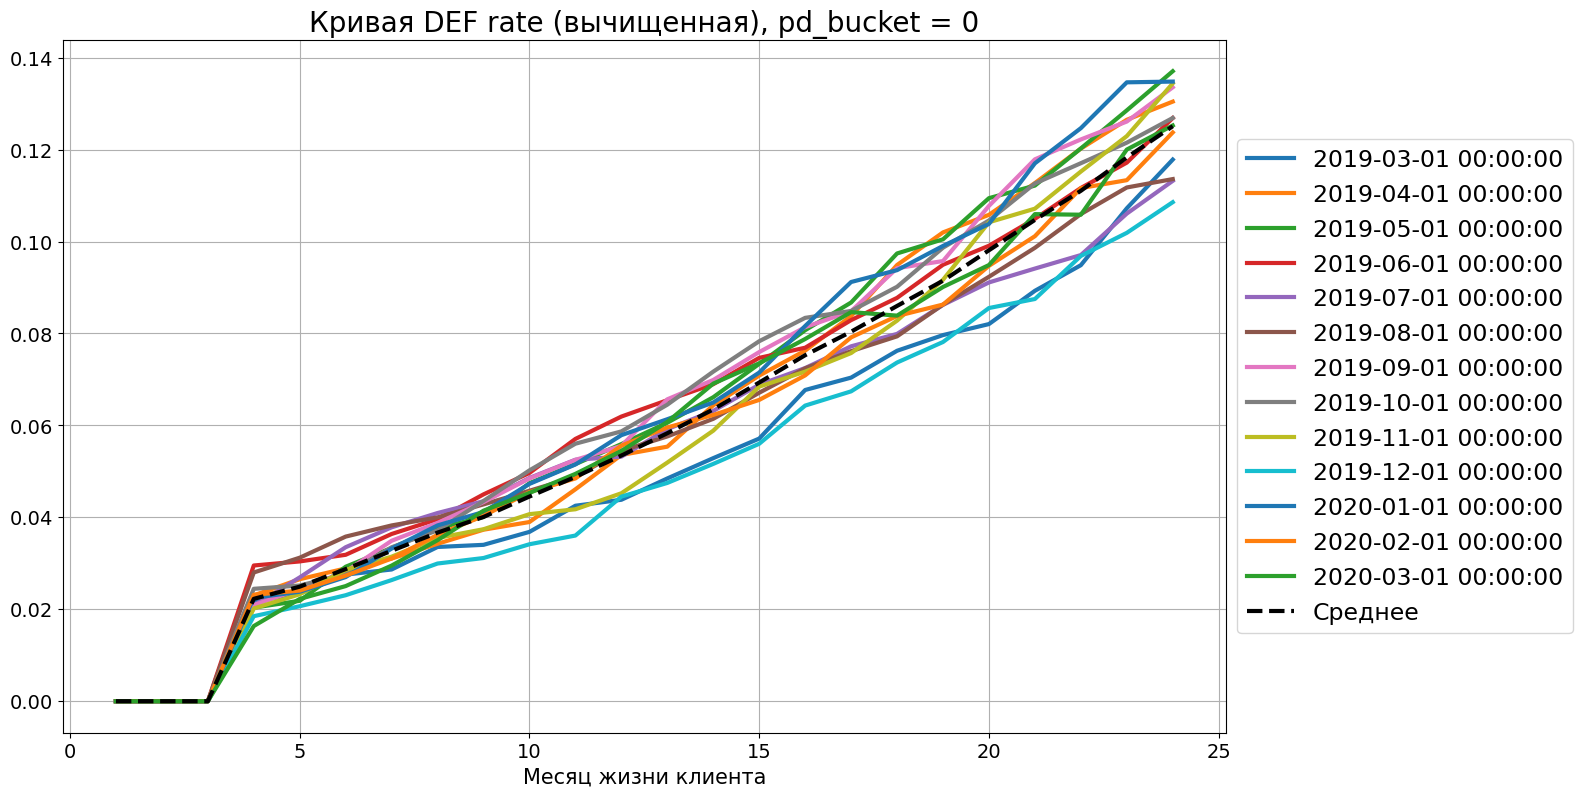

/var/folders/z_/d0y9gfdn1w5475vgs7zb15ph0000gn/T/ipykernel_5244/235578999.py:6: FutureWarning: The provided callable <function sum at 0x1047382c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"fitted_feature": np.sum})


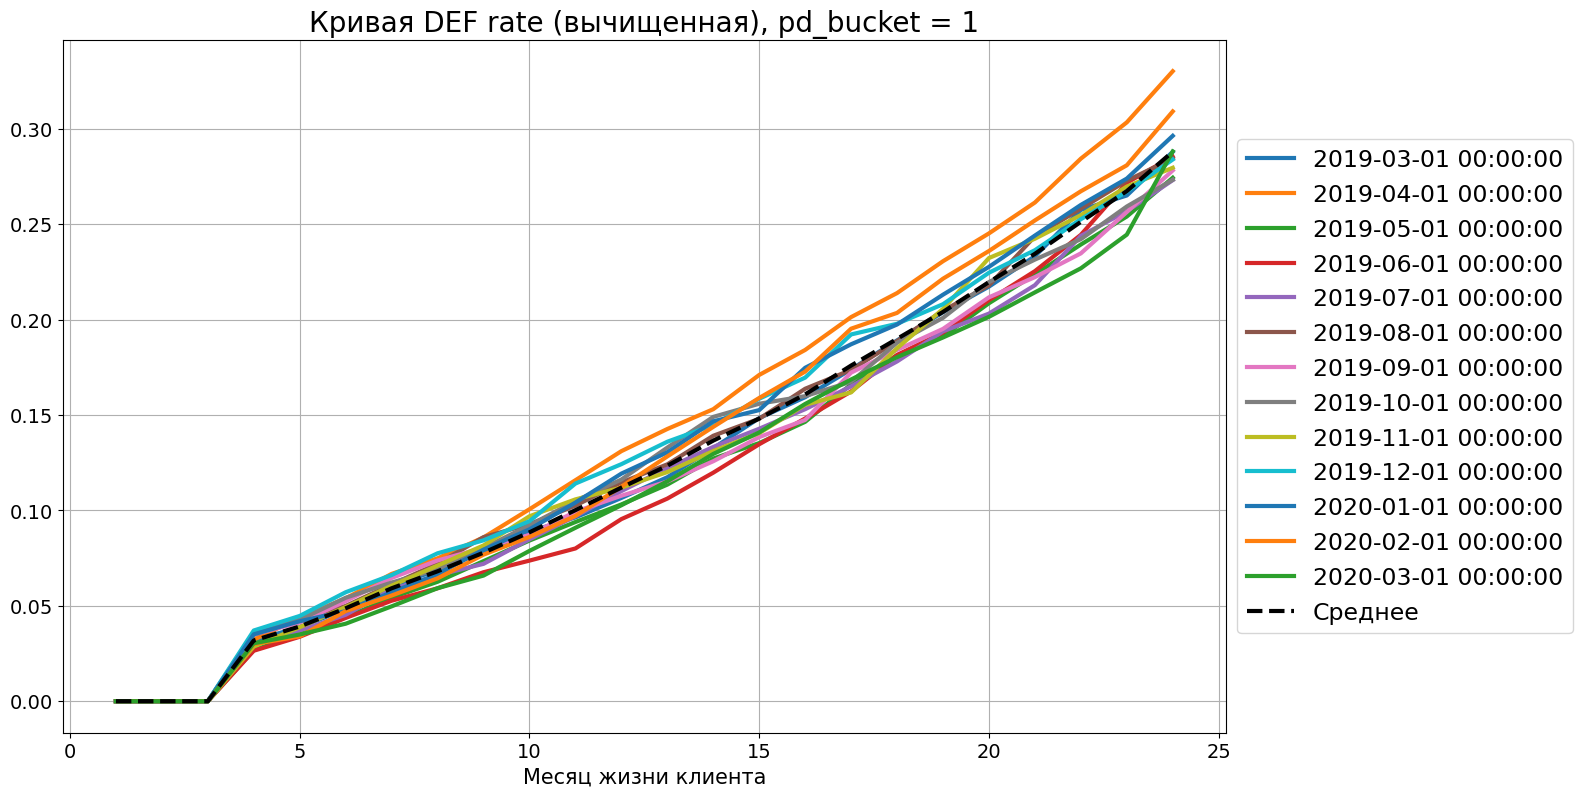

/var/folders/z_/d0y9gfdn1w5475vgs7zb15ph0000gn/T/ipykernel_5244/235578999.py:6: FutureWarning: The provided callable <function sum at 0x1047382c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"fitted_feature": np.sum})


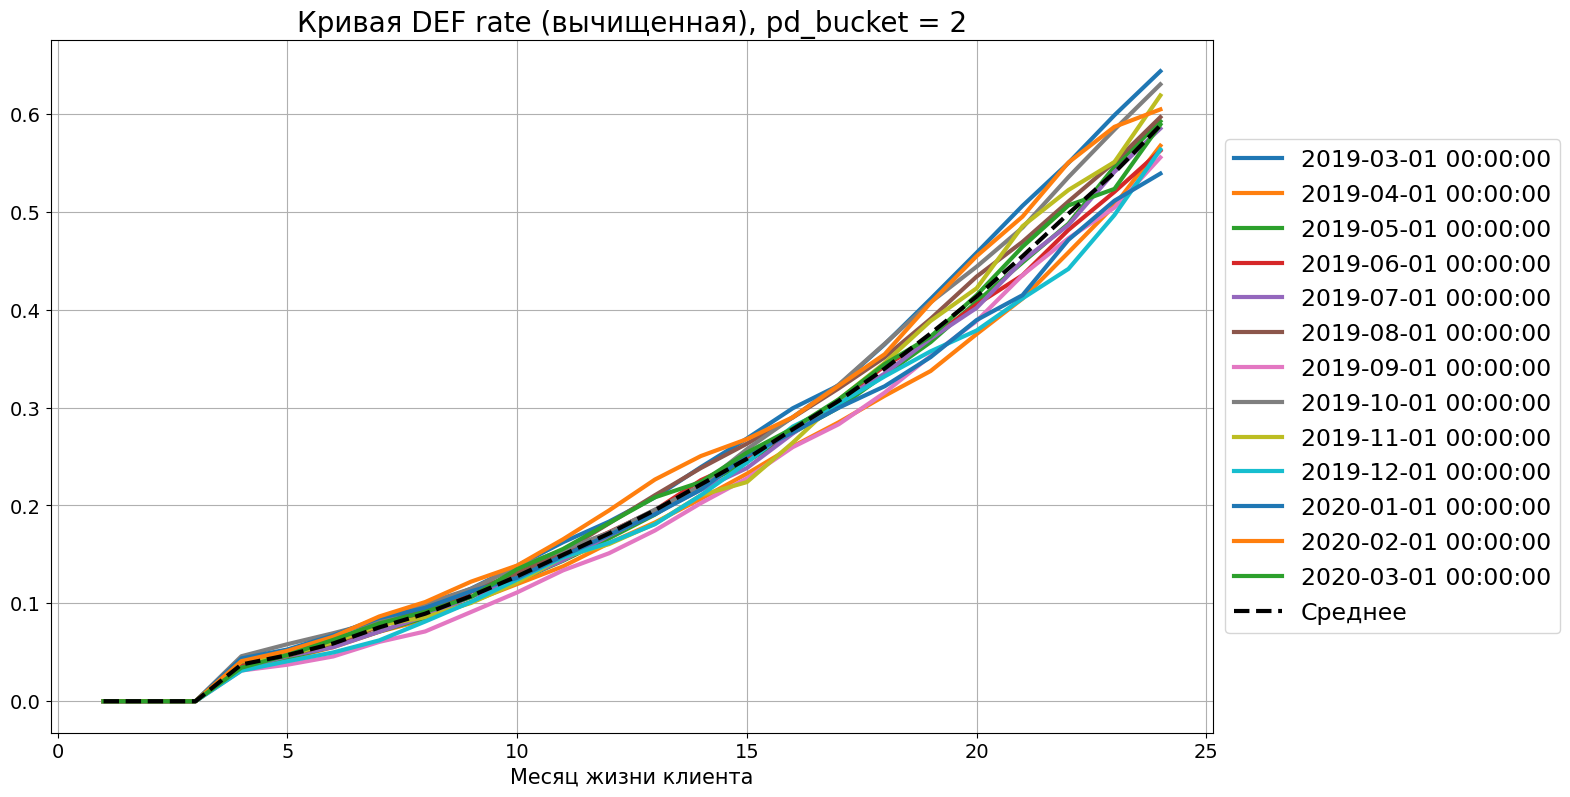

In [19]:
def plot_def_rate_mean(pd_bucket):
    (
        res_def["fitted_data"]
        .query("pd_bucket == @pd_bucket")
        .groupby(["gen_month_dt", "statement_num"])
        .agg({"fitted_feature": np.sum})
        .unstack("gen_month_dt")["fitted_feature"]
        .plot(ax=None, figsize=(15, 9), grid=True, lw=3)
    )

    def_rate_mean.loc[pd_bucket, "Среднее"].plot(
        figsize=(15, 9),
        grid=True,
        lw=3,
        color="Black",
        ls="dashed",
    )

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
    plt.title(
        f"Кривая DEF rate (вычищенная), pd_bucket = {pd_bucket}",
        size=20,
    )
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis="both", which="major", labelsize=14)
    plt.show()


for b in sorted(df["pd_bucket"].unique()):
    plot_def_rate_mean(b)


Средние кривые для старых и новых поколений не лежат системно выше или ниже друг друга. Поэтому использовал обычное (невзвешенное) среднее по винтажам.

### Сглаживание средних кривых (0.5 баллов) 

Рассмотри несколько функций для сглаживания кривой (можешь взять готовые из семинара, либо реализовать свои).

In [20]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res["Линейная функция"] = df["Среднее"]  # Копируем средние значения
    linear_coeff = np.polyfit(
        np.arange(start, finish + 1), df.loc[start:finish, "Среднее"], 1
    )  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)  # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, "Линейная функция"] = linear_coeff(
        np.arange(start, finish + 1)
    )  # Записываем приближение
    df_res.loc[finish + 1 :, "Линейная функция"] = linear_coeff(
        finish + 1
    )  # Продолжаем кривую константой
    return df_res


def polynom_approximation(df, start=1, finish=20, degree=1):
    df_res = pd.DataFrame(df)
    df_res["Полином"] = df["Среднее"]
    linear_coeff = np.polyfit(
        np.arange(start, finish + 1), df.loc[start:finish, "Среднее"], degree
    )  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)
    df_res.loc[start:finish, "Полином"] = linear_coeff(np.arange(start, finish + 1))
    df_res.loc[finish + 1 :, "Полином"] = linear_coeff(finish + 1)
    return df_res


def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [
        df_res.loc[i, "Среднее"] for i in np.arange(1, start + 1)
    ]  # Начальные значения копируем
    for n in range(start, len(df_res["Среднее"])):
        result.append(
            float(alpha * df_res.loc[n + 1, "Среднее"] + (1 - alpha) * result[n - 1])
        )  # Делаем сглаживание
    df_res["Скользящее среднее"] = result
    return df_res

In [21]:
df_linear = (
    def_rate_mean.query("pd_bucket == 0")
    .reset_index()
    .set_index(["statement_num"])
)

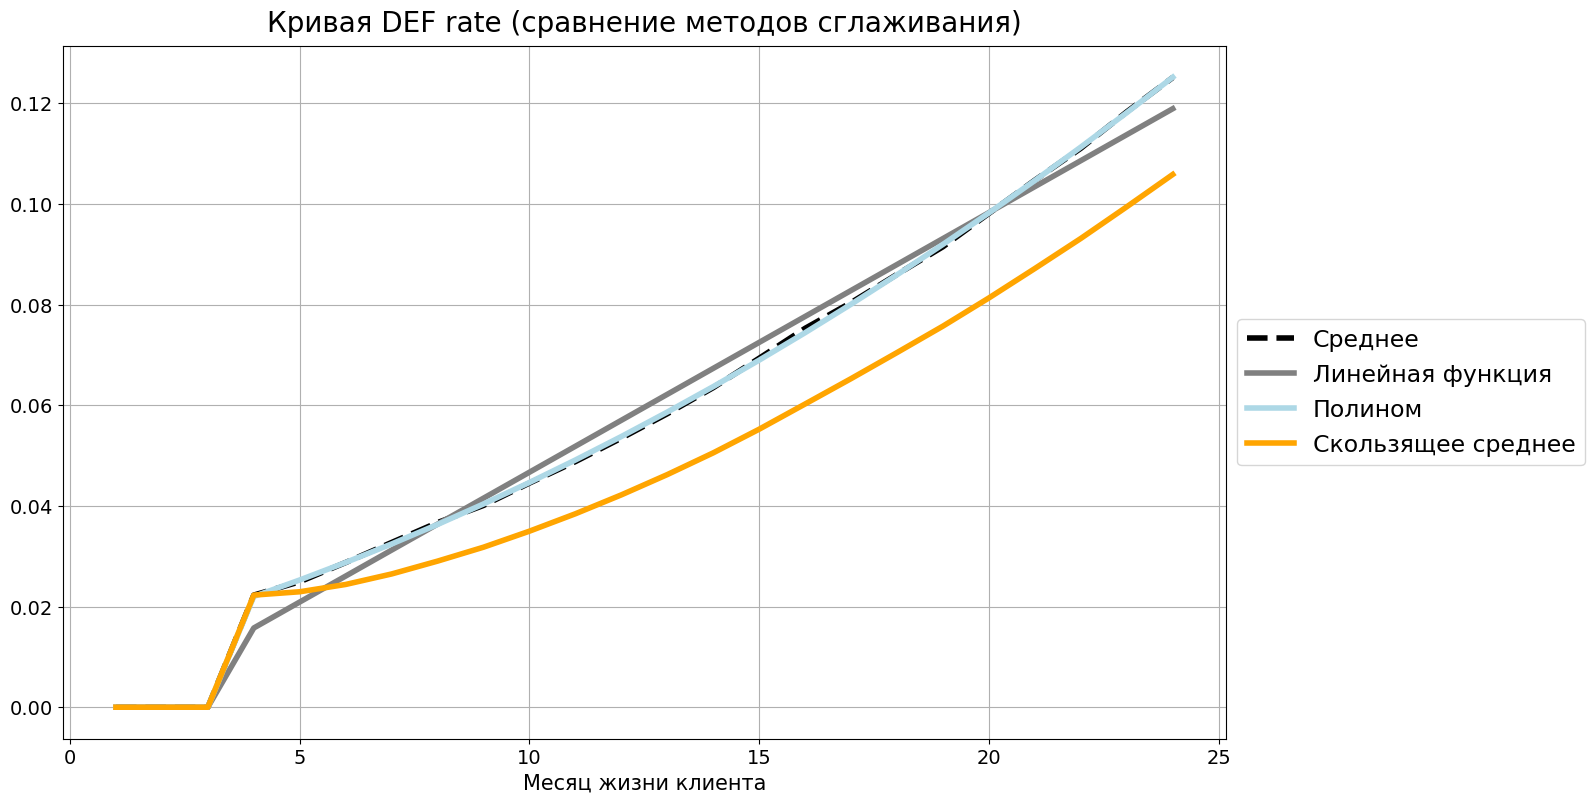

In [22]:
df_linear = linear_approximation(df_linear, 4, 24)
df_polynom = polynom_approximation(df_linear, 4, 24, 2)
df_smooth = exponential_smoothing(df_polynom, 4, 24, 0.25)

plt.figure(figsize=(15, 9))

df_smooth["Среднее"].plot(grid=True, color="Black", linestyle="--", lw=4)
df_smooth["Линейная функция"].plot(grid=True, color="Gray", linestyle="-", lw=4)
df_smooth["Полином"].plot(grid=True, color="LightBlue", linestyle="-", lw=4)
df_smooth["Скользящее среднее"].plot(grid=True, color="Orange", linestyle="-", lw=4)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Кривая DEF rate (сравнение методов сглаживания)", size=20, verticalalignment="bottom")
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

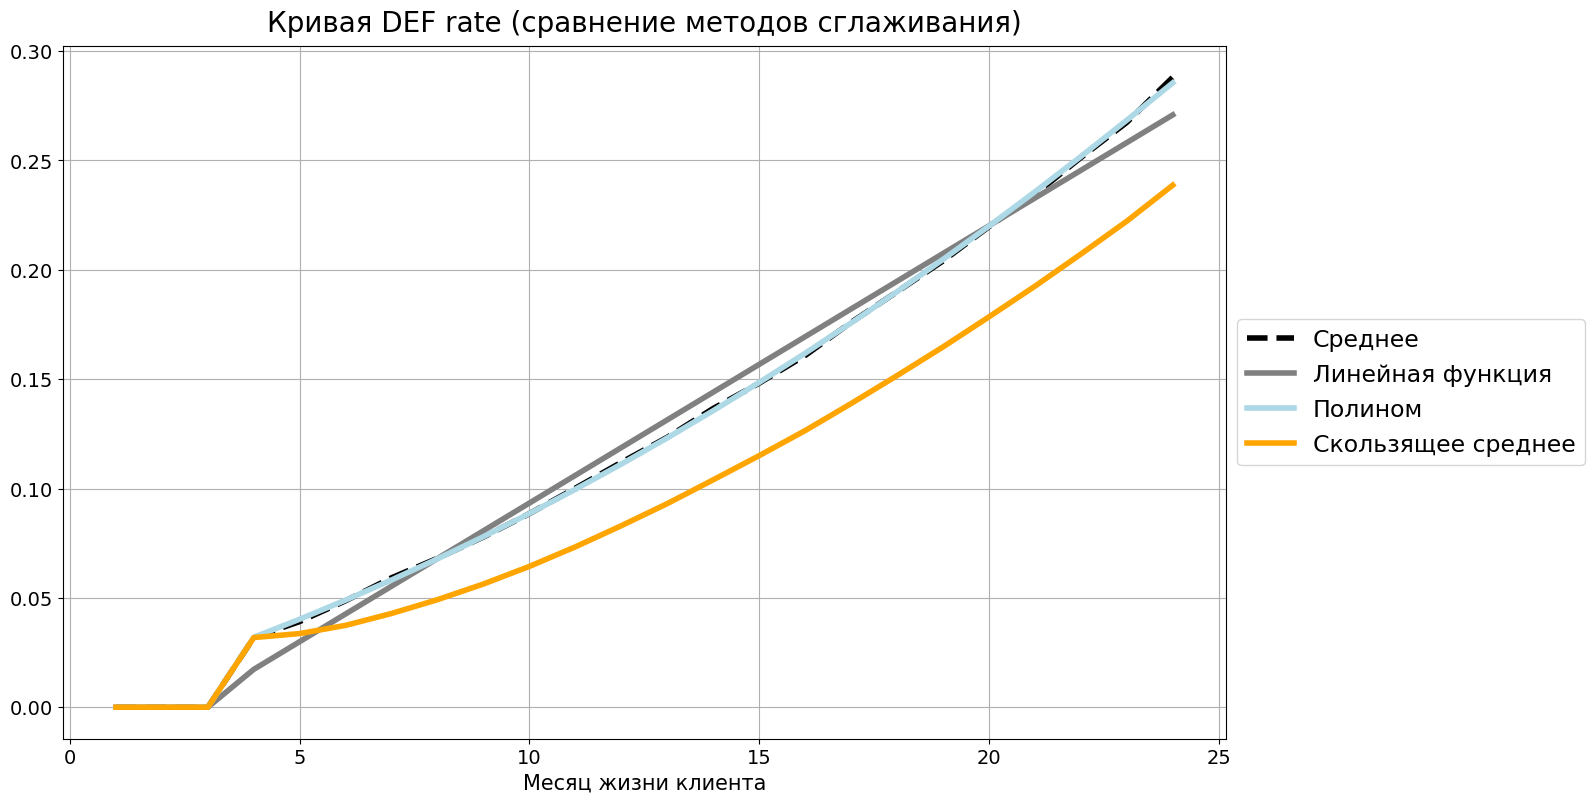

In [23]:
df_linear = (
    def_rate_mean.query("pd_bucket == 1")
    .reset_index()
    .set_index(["statement_num"])
)

df_linear = linear_approximation(df_linear, 4, 24)
df_polynom = polynom_approximation(df_linear, 4, 24, 2)
df_smooth = exponential_smoothing(df_polynom, 4, 24, 0.25)

plt.figure(figsize=(15, 9))

df_smooth["Среднее"].plot(grid=True, color="Black", linestyle="--", lw=4)
df_smooth["Линейная функция"].plot(grid=True, color="Gray", linestyle="-", lw=4)
df_smooth["Полином"].plot(grid=True, color="LightBlue", linestyle="-", lw=4)
df_smooth["Скользящее среднее"].plot(grid=True, color="Orange", linestyle="-", lw=4)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Кривая DEF rate (сравнение методов сглаживания)", size=20, verticalalignment="bottom")
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

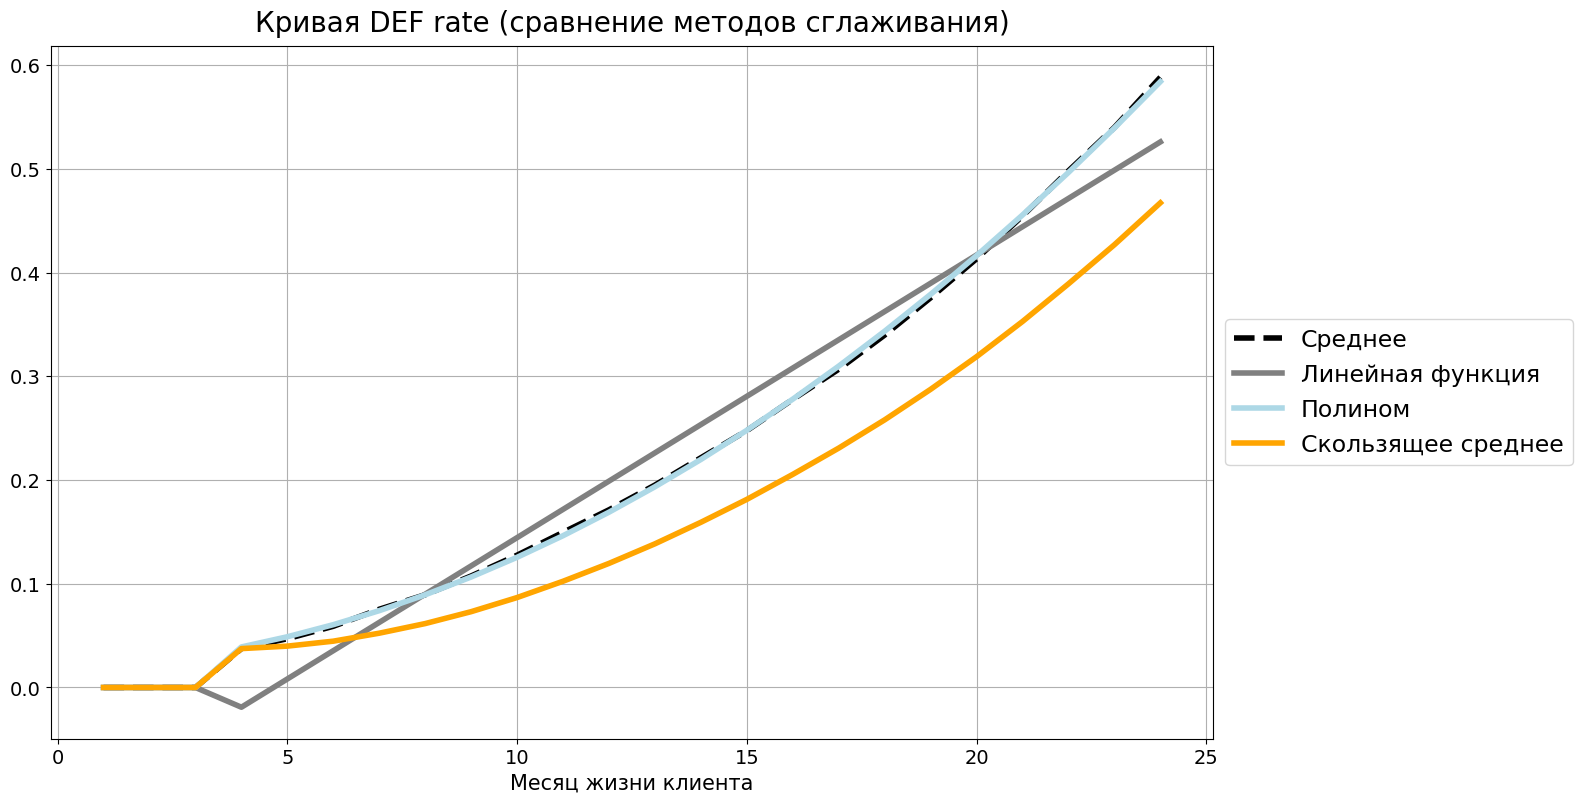

In [24]:
df_linear = (
    def_rate_mean.query("pd_bucket == 2")
    .reset_index()
    .set_index(["statement_num"])
)

df_linear = linear_approximation(df_linear, 4, 24)
df_polynom = polynom_approximation(df_linear, 4, 24, 2)
df_smooth = exponential_smoothing(df_polynom, 4, 24, 0.25)

plt.figure(figsize=(15, 9))

df_smooth["Среднее"].plot(grid=True, color="Black", linestyle="--", lw=4)
df_smooth["Линейная функция"].plot(grid=True, color="Gray", linestyle="-", lw=4)
df_smooth["Полином"].plot(grid=True, color="LightBlue", linestyle="-", lw=4)
df_smooth["Скользящее среднее"].plot(grid=True, color="Orange", linestyle="-", lw=4)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Кривая DEF rate (сравнение методов сглаживания)", size=20, verticalalignment="bottom")
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

#### Вывод: укажи выбранную функцию и обоснуй свой выбор. Были ли точки, к которым не применил(-a) сглаживание? Почему?

Выбрал полиномиальную аппроксимацию второй степени. Сглаживание не применялось к первым месяцам жизни кредита (4 месяца), так как в этот период DEF rate либо равен нулю, либо определяется особенностями определения дефолта, а не поведением клиента

### Отрисуй сглаженные кривые по всем трем бакетам PD

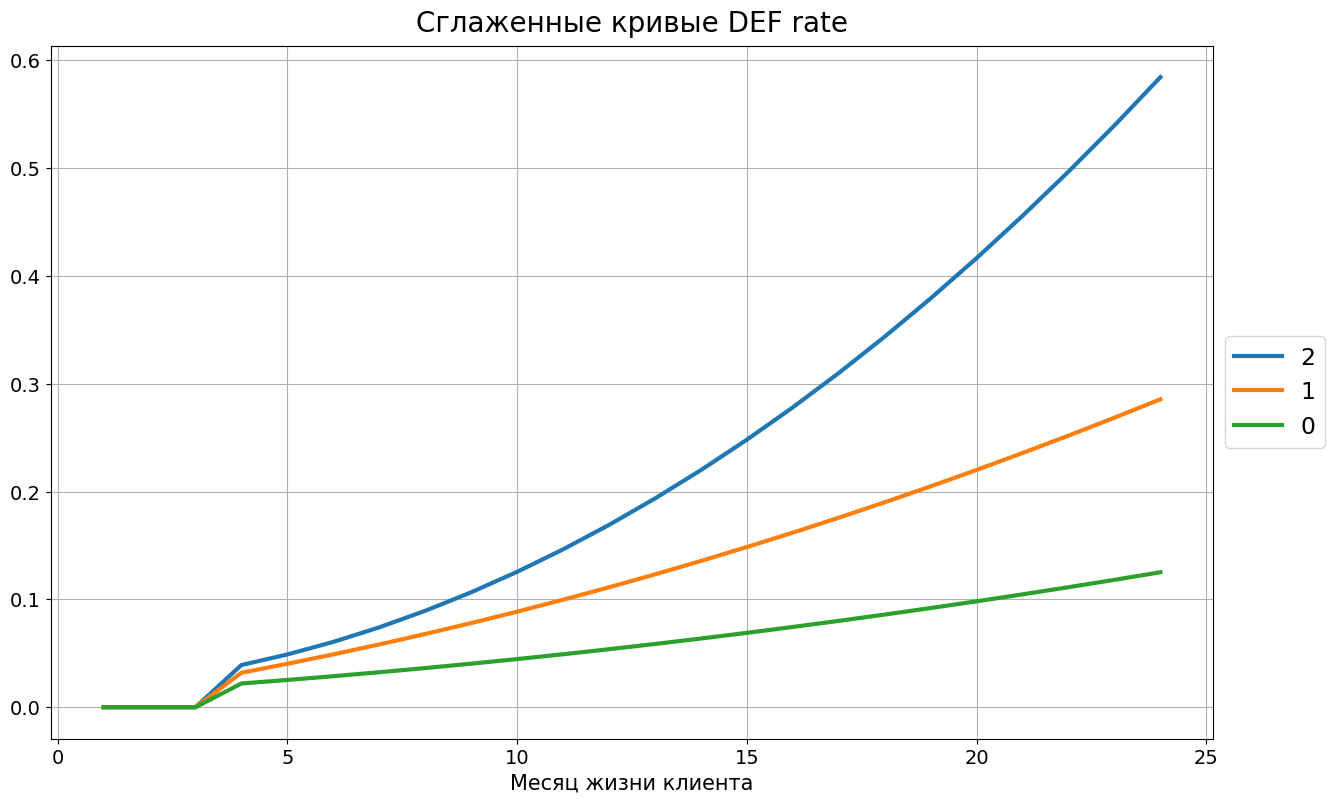

In [25]:
# код здесь
df_smooth_result = pd.DataFrame()

for bucket in sorted(buckets, reverse=True):
    df_temp = (
        def_rate_mean.query("pd_bucket == " + str(bucket))
        .reset_index()
        .set_index(["statement_num"])
    )
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 4, 24, 2)["Полином"]

df_smooth_result.plot(figsize=(15, 9), grid=True, lw=3)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Сглаженные кривые DEF rate", size=20, verticalalignment="bottom")
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

In [26]:
df_smooth_result.to_csv("def_rate.csv")

# Внедрение в NPV-модель

## Добавь в NPV-модель метод с расчетом DEF rate по твоей кривой

In [27]:
# Код NPV-модели с прошлого семинара

import numpy as np

class NPVModel:

    avg_missed_payments = 1.5
    recovery = 0.50
    dlq_penalty_amount = 500
    oper_costs = 100
    collection_costs = 600
    tax_rate = 0.20
    discounting_rate = 0.30
    eq_req = 0.125
    cost_of_funds = 0.16
    dlq_ratio = np.ones(101)*0.20
    dlq_ratio[0] = 0
    shift = 4
    clo_rate = 1 / (np.arange(shift, shift + 101) ** 2)
    acquisition_cost = 1000
    
    insurance_premium_rate = 0.005 # 0.5% от лимита
    insurance_share_cur = 0.4 # доля клиентов со страховкой среди CUR
    insurance_share_dlq = 0.6 # доля клиентов со страховкой среди DLQ
    insurance_claim_prob_month = 0.001  # 0.1% вероятность страхового случая месячная

    def __init__(self):
        pass

    def model_balance_calculations(self, amount, rate, term):
        '''
        Расчет модельных баланса, выплаченных процентов, регулярного платежа
        :param amount: Сумма кредита
        :param rate: Ставка
        :param term: Срок
        :return:
        balance : np.array(101) : остаток тела долга по кредиту на каждый месяц
        interest : np.array(101) : выплата по процентам каждый месяц
        regular_payment : float : размер регулярного платежа
        '''

        regular_payment = round(amount * (rate / 12) *\
                                (1 + (rate / 12)) / (1 - ((1 + rate / 12) ** (-term))))
        # График баланса и процентов
        balance = np.zeros(101)
        interest = np.zeros(101)
        balance[0] = amount

        for i in range(1, term + 1):
            int_payment = balance[i - 1] * rate / 12
            debt_payment = regular_payment - int_payment
            balance[i] = max(0, round(balance[i - 1] - debt_payment))
            interest[i] = int_payment
        return balance, interest, regular_payment

    def distribution_calc(self, portfolio_distribution, pd=None, pa=None):
        '''
        Расчет распределения по статусам
        :param portfolio_distribution: график распределения по статусам
        :return:
        cur_dist : np.array(101) : доля клиентов в статусе CUR на каждый месяц
        dlq_dist : np.array(101) : доля клиентов в статусе DLQ на каждый месяц
        act_dist : np.array(101) : доля клиентов в статусе ACT на каждый месяц
        def_dist : np.array(101) : доля клиентов в статусе DEF на каждый месяц
        clo_dist : np.array(101) : доля клиентов в статусе CLO на каждый месяц
        '''
        
        cur_dist = portfolio_distribution['CUR']
        dlq_dist = portfolio_distribution['DLQ']
        act_dist = cur_dist + dlq_dist
        def_dist = portfolio_distribution['DEF'] 
        clo_dist = portfolio_distribution['CLO']


        return cur_dist, dlq_dist, act_dist, def_dist, clo_dist

    def cur_balance_calc(self, model_balance, cur_dist):
        '''
        Расчет модельного баланса в статусе CUR
        :param model_balance: плановый график баланса
        :param cur_dist: доля клиентов в статусе CUR на каждый месяц
        :return:
        principal_balance_cur : np.array(101) : principal balance в статусе CUR
        gross_balance_cur : np.array(101) : gross balance в статусе CUR
        '''
        principal_balance_cur = model_balance*cur_dist
        gross_balance_cur = model_balance*cur_dist
        return principal_balance_cur, gross_balance_cur

    def dlq_balance_calc(self, model_balance, regular_payment, dlq_dist):
        '''
        Расчет модельного баланса в статусе DLQ
        :param model_balance: плановый график баланса
        :param regular_payment: размер регулярного платежа
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        principal_balance_dlq : np.array(101) : principal balance в статусе DLQ
        gross_balance_dlq : np.array(101) : gross balance в статусе DLQ
        '''
        principal_balance_dlq = np.append(model_balance[1:], model_balance[-1])*dlq_dist
        gross_balance_dlq = (model_balance + regular_payment*self.avg_missed_payments)*dlq_dist
        return principal_balance_dlq, gross_balance_dlq

    def act_balance_calc(self, principal_balance_cur, principal_balance_dlq, gross_balance_cur, gross_balance_dlq):
        '''
        Расчет модельного баланса в статусе ACT
        :param principal_balance_cur: principal balance в статусе CUR
        :param principal_balance_dlq: principal balance в статусе DLQ
        :param gross_balance_cur: principal balance в статусе CUR
        :param gross_balance_dlq: principal balance в статусе DLQ
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        principal_balance_act : np.array(101) : principal balance в статусе ACT
        gross_balance_act : np.array(101) : gross balance в статусе ACT
        '''
        principal_balance_act = principal_balance_cur + principal_balance_dlq
        gross_balance_act = gross_balance_cur + gross_balance_dlq
        return principal_balance_act, gross_balance_act

    def def_balance_calc(self, model_balance, regular_payment, def_dist):
        '''
        Расчет модельного баланса в статусе DEF
        :param model_balance: плановый график баланса
        :param regular_payment: размер регулярного платежа
        :param def_dist: доля клиентов в статусе DEF на каждый месяц
        :return:
        principal_balance_def : np.array(101) : principal balance в статусе DEF
        gross_balance_def : np.array(101) : gross balance в статусе DEF
        '''
        principal_balance_def = np.zeros(101)
        gross_balance_def = np.zeros(101)

        def_dist_change = def_dist[4:] - def_dist[3:-1]
        principal_balance_def[4:] = np.cumsum(model_balance[:-4] * def_dist_change)
        gross_balance_def[4:] = np.cumsum((model_balance[4:] + 4 * regular_payment) * def_dist_change)

        return principal_balance_def, gross_balance_def

    def profit_calc(self, principal_balance_act, principal_balance_def, term, rate, dlq_dist):
        '''

        :param principal_balance_act: principal balance в статусе ACT
        :param principal_balance_def: principal balance в статусе DEF
        :param term: срок кредита
        :param rate: тавка по кредиту
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        profit : np.array(101) : доход на каждый месяц
        '''
        interest_profit = principal_balance_act*rate/12
        penatly_profit = dlq_dist*self.dlq_penalty_amount

        new_def_balance = np.append(principal_balance_def[1:], 0) - principal_balance_def
        recovery_profit = new_def_balance*self.recovery

        profit = interest_profit + recovery_profit + penatly_profit
        profit[term+1:] = 0

        return profit

    def loss_calc(self, gross_balance_act, principal_balance_def, term, act_dist, dlq_dist, def_dist):
        '''

        :param gross_balance_act: gross balance в статусе ACT
        :param principal_balance_def: principal balance в статусе DEF
        :param term: срок кредита
        :param act_dist: доля клиентов в статусе ACT на каждый месяц
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :param def_dist: доля клиентов в статусе DEF на каждый месяц
        :return:
        loss : np.array(101) : лосс на каждый месяц
        '''
        oper_loss = np.append(act_dist[1:], 0)*self.oper_costs
        loan_loss =  principal_balance_def - np.append(0, principal_balance_def[:-1])
        collection_loss = (np.append(dlq_dist[1:], 0) + np.append(def_dist[1:], 0))*self.collection_costs

        prev_gross_balance_act = np.append(gross_balance_act[0], gross_balance_act[1:])
        cost_of_funds_loss = prev_gross_balance_act*(1 - self.eq_req)*self.cost_of_funds/12

        loss = loan_loss + cost_of_funds_loss + oper_loss + collection_loss
        loss[term+1:] = 0

        return loss, loan_loss, cost_of_funds_loss, oper_loss, collection_loss

    def assets_liabilities_calc(self, gross_balance_act):
        '''

        :param gross_balance_act: gross balance в статусе ACT
        :return:
        assets : np.array(101) : активы в проекте
        eq_req_curve : np.array(101) : активы, обеспеченные капиталом
        fund_req_curve : np.array(101) : активы, обеспеченные фондами
        '''

        # assets
        assets = gross_balance_act

        #liabilities
        eq_req_curve = assets*self.eq_req
        fund_req_curve = assets*(1 - self.eq_req)

        return assets, eq_req_curve, fund_req_curve

    def niat_calc(self, profit, loss):
        '''
        Расчет NIAT
        :param profit: суммарный доход на каждый месяц
        :param loss: суммарный лосс на каждый месяц
        :return:
        nibt : np.array(101) : прибыль до налогообложения
        niat : np.array(101) : прибыль после налогообложения
        tax : np.array(101) : налог в каждом месяце
        '''

        nibt = profit - loss
        tax = nibt*self.tax_rate
        niat = nibt - tax

        return nibt, niat, tax

    def cashflow_calc(self, principal_balance_act, principal_balance_def, amount, profit,
                      cost_of_funds_loss, oper_costs, collection_costs, tax, niat, eq_req_curve, fund_req_curve):
        '''
        Расчет денежных потоков
        :param principal_balance_act: principal balance в статусе DEF
        :param principal_balance_def: principal balance в статусе DEF
        :param amount: срок кредита
        :param profit: доход на каждый месяц
        :param cost_of_funds_loss: лоссы на фондирование
        :param oper_costs: операционные расходы
        :param collection_costs: расходы на коллекшн
        :param tax: налог в каждом месяце
        :param niat: доход после налогообложения
        :param eq_req_curve: активы, обеспеченные капиталом
        :param fund_req_curve: активы, обеспеченные фондами
        :return:
        cf_to_client : np.array(101) : денежный поток к клиенту
        cf_to_shareholders : np.array(101) : денежный поток к акционерам
        cf_to_debtholders : np.array(101) : денежный поток к фондам
        cf_to_cost_and_tax : np.array(101) : денежный поток на косты и налоги
        '''
        # client
        delta_principal_balance_act = (np.append(0, principal_balance_act[:100]) - principal_balance_act)
        delta_principal_balance_def = (np.append(0, principal_balance_def[:100]) - principal_balance_def)
        repayments = delta_principal_balance_act - delta_principal_balance_def + profit
        cf_to_client = np.append(amount, -repayments[1:])

        # debtoholder
        fund_req_ch = fund_req_curve - np.append(fund_req_curve[0], fund_req_curve[:-1])
        fund_req_change = np.append(fund_req_curve[0], fund_req_ch[1:])
        cf_to_debtholders = cost_of_funds_loss - fund_req_change

        # shareholders
        eq_req_ch = eq_req_curve - np.append(eq_req_curve[0], eq_req_curve[:-1])
        cf_to_shareholders = niat - np.append(eq_req_curve[0], eq_req_ch[1:])

        # cost and tax
        cf_to_cost_and_tax = oper_costs + collection_costs + tax

        return cf_to_client, cf_to_shareholders, cf_to_debtholders, cf_to_cost_and_tax
        
    def npv_calc(self, amount, rate, term, pd=None):
        '''
        Расчет NPV с внутренним вычислением portfolio_distribution
        :param amount: сумма кредита
        :param rate: ставка по кредиту
        :param term: срок кредита
        :param def_rate: доля дефолтных клиентов к концу срока
        :param clo_rate: доля закрытых клиентов к концу срока
        :param pd: вероятность дефолта к 12-ому месяцу
        :param pa: вероятность полного досрочного погашения к 6-ому месяцу
        :return: npv: чистая приведенная стоимость кредита
        '''

        # Считаем балансы
        model_balance, interest, regular_payment = self.model_balance_calculations(amount, rate, term)
        
        # Рассчитываем распределение по статусам
        cur_dist = np.zeros(101)
        dlq_dist = np.zeros(101)
        def_dist = np.zeros(101)
        clo_dist = np.zeros(101)
        act_dist = np.zeros(101)
        
        # В начале все клиенты в статусе CUR
        act_dist[0] = 1
        cur_dist[0] = 1
        
        self.def_rate = self.def_rate_calc(pd)
        
        for i in range(1, term + 1):
            # clo_dist[i] = self.clo_rate[i] * act_dist[i - 1]
            # def_dist[i] = self.def_rate[i] * act_dist[i - 1]
            # act_dist[i] = act_dist[i - 1] - clo_dist[i] - def_dist[i]
            # dlq_dist[i] = self.dlq_ratio[i] * act_dist[i]
            # cur_dist[i] = act_dist[i] - dlq_dist[i]
            clo_dist[i] = clo_dist[i - 1] + self.clo_rate[i] * act_dist[i - 1]
            def_dist[i] = def_dist[i - 1] + self.def_rate[i] * act_dist[i - 1]
            act_dist[i] = 1 - clo_dist[i] - def_dist[i]
            dlq_dist[i] = self.dlq_ratio[i] * act_dist[i]
            cur_dist[i] = act_dist[i] - dlq_dist[i]
            

        portfolio_distribution = {
            'CUR': cur_dist,
            'DLQ': dlq_dist,
            'DEF': def_dist,
            'CLO': clo_dist
        }

        # Считаем распределение
        cur_dist, dlq_dist, act_dist, def_dist, clo_dist = self.distribution_calc(portfolio_distribution)

        # Считаем балансы
        principal_balance_cur, gross_balance_cur = self.cur_balance_calc(model_balance, cur_dist)
        principal_balance_dlq, gross_balance_dlq = self.dlq_balance_calc(model_balance, regular_payment, dlq_dist)
        principal_balance_act, gross_balance_act = self.act_balance_calc(principal_balance_cur, principal_balance_dlq, gross_balance_cur, gross_balance_dlq)
        principal_balance_def, gross_balance_def = self.def_balance_calc(model_balance, regular_payment, def_dist)

        # Считаем профиты
        profit = self.profit_calc(principal_balance_act, principal_balance_def, term, rate, dlq_dist)
        loss, loan_loss, cost_of_funds_loss, oper_loss, collection_loss = self.loss_calc(gross_balance_act, principal_balance_def,
                                                                                        term, act_dist, dlq_dist, def_dist)

        # УЧЕТ СТРАХОВКИ
        
        # прибыль со страховки: 0.5% от лимита, подключена у 40% CUR и 60% DLQ
        insured_share_curve = (cur_dist * self.insurance_share_cur) + (dlq_dist * self.insurance_share_dlq)
        insurance_income = amount * self.insurance_premium_rate * insured_share_curve

        # выплаты при наступлении страхового случая: 0.1% месячная вероятность * "текущая задолженность" у застрахованных
        # "текущая задолженность" как gross_balance статуса (для DLQ включает хвост просрочки)
        insured_gross_debt = (gross_balance_cur * self.insurance_share_cur) + (gross_balance_dlq * self.insurance_share_dlq)
        insurance_payout = insured_gross_debt * self.insurance_claim_prob_month

        # обрезал после срока кредита
        insurance_income[term+1:] = 0
        insurance_payout[term+1:] = 0

        # учет страховки: прибыль со страховки в доход, выплата за страховой случай в расход
        profit = profit + insurance_income
        loss = loss + insurance_payout

        # КОНЕЦ
        
        nibt, niat, tax = self.niat_calc(profit, loss)

        # Считаем активы и денежные потоки
        assets, eq_req_curve, fund_req_curve = self.assets_liabilities_calc(gross_balance_act)
        cf_to_client, cf_to_shareholders, cf_to_debtholders, cf_to_cost_and_tax =\
            self.cashflow_calc(principal_balance_act, principal_balance_def, amount, profit, cost_of_funds_loss, oper_loss, collection_loss,
                            tax, niat, eq_req_curve, fund_req_curve)

        # Считаем NPV
        disc_curve = np.array([1 / ((1 + self.discounting_rate) ** (i / 12.)) for i in range(101)])
        pv = np.round(np.sum(disc_curve * cf_to_shareholders)).astype(int)
        npv = pv - self.acquisition_cost

        return npv
    
    
    def def_rate_calc(self, pd=None):    
        if pd <= self.pd_q1:
            b = "0"
        elif pd <= self.pd_q2:
            b = "1"
        else:
            b = "2"
    
        base = np.zeros(101)
        for idx, val in self.def_curve[b].items():
            m = int(idx)
            if m < 101:
                base[m] = float(val)
    
        base_12 = base[1:13].sum()
        scale = 0.0 if base_12 <= 1e-12 else pd / base_12
    
        def_rate = np.clip(base * scale, 0, 1)
        return def_rate

## Посчитай NPV по кредиту с параметрами

- Срок кредита 2 года
- Годовая процентная ставка 21%
- Сумма кредита 1 млн
- Страховка подключена

In [28]:
pd_q1 = df_scores["pd"].quantile(1/3)
pd_q2 = df_scores["pd"].quantile(2/3)
def_curve = pd.read_csv("def_rate.csv", index_col=0)

model = NPVModel()

model.pd_q1 = pd_q1
model.pd_q2 = pd_q2
model.def_curve = def_curve

npv = model.npv_calc(amount=1000000, term=24, rate=0.21, pd=0.03)
print("NPV:", npv)

NPV: 17291


## Построй график зависимости NPV от скора, которым ты побил(-а) DEF rate

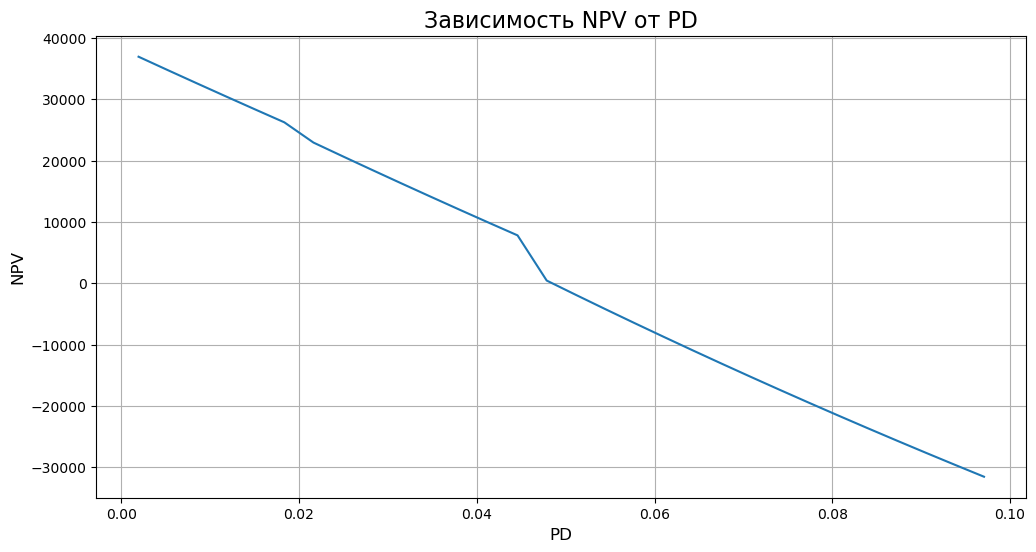

In [29]:
pd_min = df_scores["pd"].quantile(0.01)
pd_max = df_scores["pd"].quantile(0.99)

pd_grid = np.linspace(pd_min, pd_max, 30)

npv_list = []
for p in pd_grid:
    npv_list.append(model.npv_calc(amount=1000000, term=24, rate=0.21,pd=float(p)))

df_npv = pd.DataFrame({"pd": pd_grid, "npv": npv_list})
df_npv.head()

plt.figure(figsize=(12, 6))
plt.plot(df_npv["pd"], df_npv["npv"])
plt.grid(True)
plt.title("Зависимость NPV от PD", size=16)
plt.xlabel("PD", size=12)
plt.ylabel("NPV", size=12)
plt.show()